# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [15]:
import numpy as np
import scipy
from sympy.combinatorics.permutations import Permutation
import matplotlib.pyplot as plt
import time
import urllib.request
import utils

%matplotlib inline

In [2]:
QAP_INSTANCE_URL = 'https://www.opt.math.tugraz.at/qaplib/data.d/nug12.dat'

## Reading input data

In [60]:
def load_problem_instance(url):
    qap_instance_file = urllib.request.urlopen(url)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A.shape)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B.shape)

    def f(p):
        s = 0.0
        for i in range(n):
            s += (A[i, :] * B[p[i], p]).sum()
        return s

    return n, f

n, qap_objective_function = load_problem_instance(QAP_INSTANCE_URL)

Problem size: 12
Flow matrix:
 (12, 12)
Distance matrix:
 (12, 12)


## Random Sampling

In [4]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

63.52125382423401
594.0 [ 2  7  0  1  8 10  3  9 11  6  5  4]


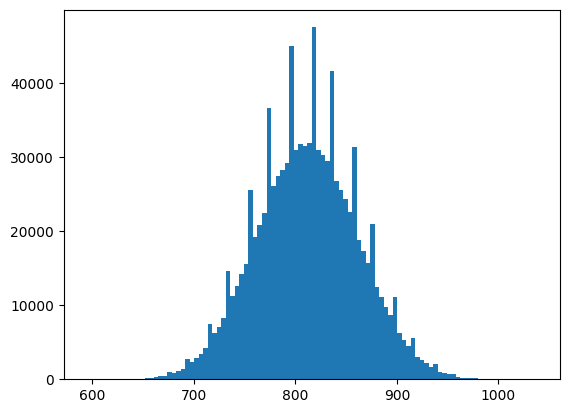

811.976276 49.69472331316298


In [5]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [4]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [17]:
def SA(n, qap_objective_function, T = 500000, radius = 1, alpha = 1.0):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    return p, costs

578.0


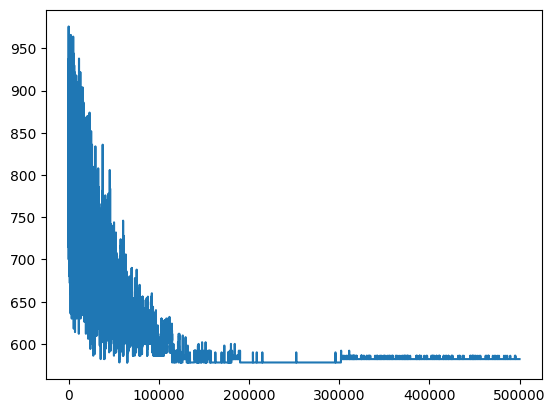

In [8]:
p, costs = SA(n, qap_objective_function)
print(min(costs))
plt.figure()
plt.plot(costs)
plt.show()

## a) Solve for other instances

In [9]:
def solve(problem_url, **sa_params):
	n, f = load_problem_instance(problem_url)
	_, costs = SA(n, f, **sa_params)
	plt.figure()
	plt.plot(costs)
	plt.title(f"Minimal cost {min(costs)}")
	plt.show()

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

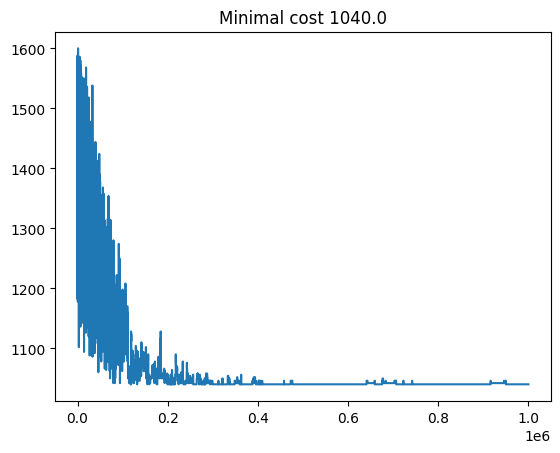

In [13]:
solve("https://www.opt.math.tugraz.at/qaplib/data.d/nug14.dat", radius=3, T=10**6)

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

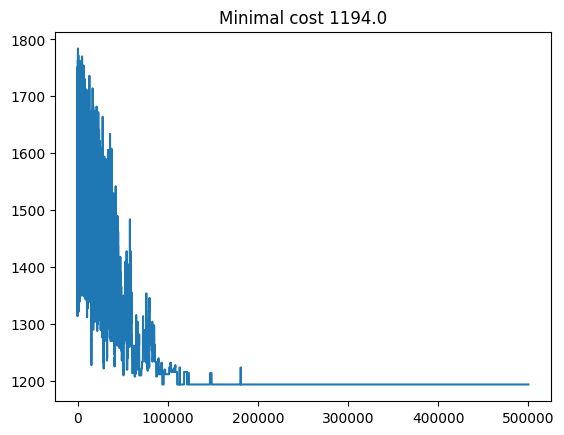

In [15]:
solve("https://www.opt.math.tugraz.at/qaplib/data.d/nug15.dat", radius=3, alpha=0.7)

Problem size: 20
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6. 7.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [3. 4. 5. 6. 7. 2. 3. 4

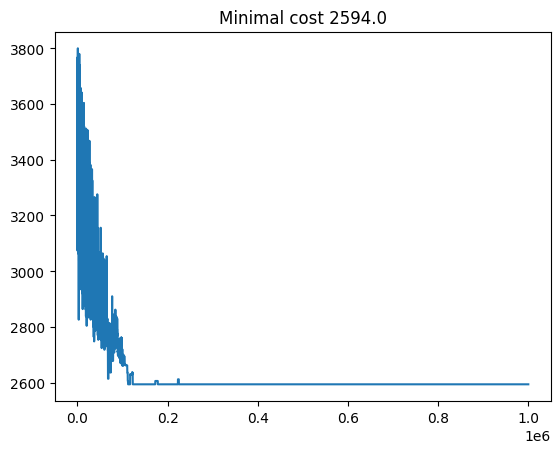

In [ ]:
solve("https://www.opt.math.tugraz.at/qaplib/data.d/nug20.dat", radius = 2, T = 10**6)

## b) SA Histogram

In [23]:
T = 100000
n, f = load_problem_instance("https://www.opt.math.tugraz.at/qaplib/data.d/nug12.dat")
permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :], _ = SA(n, f, T = 10**2)
    costs[i] = f(permutations[i, :])

p = permutations[costs.argmin(), :]

print(f(p), p)
plt.figure()
plt.hist(costs, bins=100)
plt.show()
print(costs.mean(), costs.std())

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## c) Successes and Acceptable Losses ratios

In [5]:
def SA(n, qap_objective_function, T = 500000, radius = 1, alpha = 1.0):
    history = {
        "success": [],
        "acploss": []
    }
    success = acploss = 0
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(0, T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            success += 1
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            acploss += 1
        costs[t] = p_cost
        history["success"].append(success / (t + 1))
        history["acploss"].append(acploss / (t + 1))
    return history["success"], history["acploss"]

In [6]:
n, f = load_problem_instance("https://www.opt.math.tugraz.at/qaplib/data.d/nug12.dat")

Problem size: 12
Flow matrix:
 (12, 12)
Distance matrix:
 (12, 12)


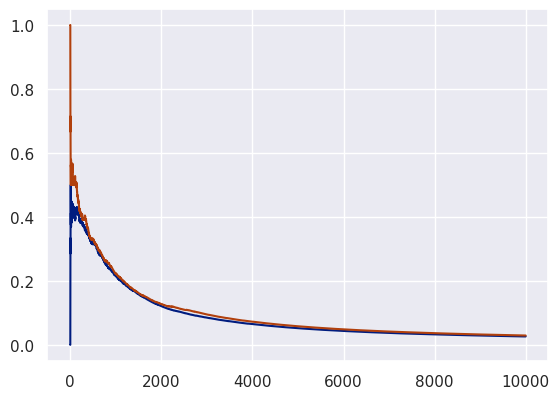

<Figure size 640x480 with 0 Axes>

In [37]:
s, l = SA(n, f, T = 10**4, radius=1, alpha=1.0)
utils.quickplot(s, l)

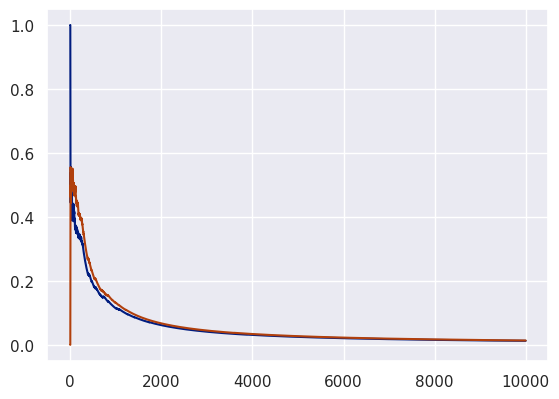

<Figure size 640x480 with 0 Axes>

In [38]:
s, l = SA(n, f, T = 10**4, radius=10, alpha=1.0)
utils.quickplot(s, l)

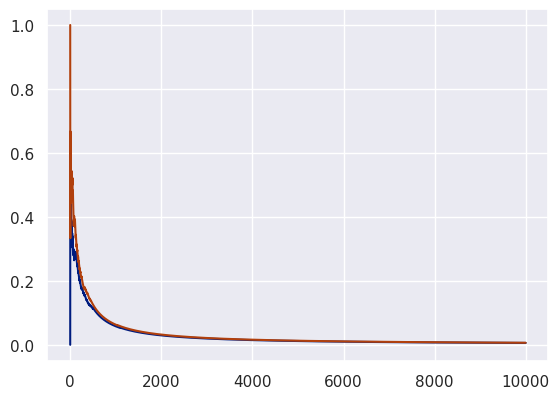

<Figure size 640x480 with 0 Axes>

In [39]:
s, l = SA(n, f, T = 10**4, radius=1, alpha=5.0)
utils.quickplot(s, l)

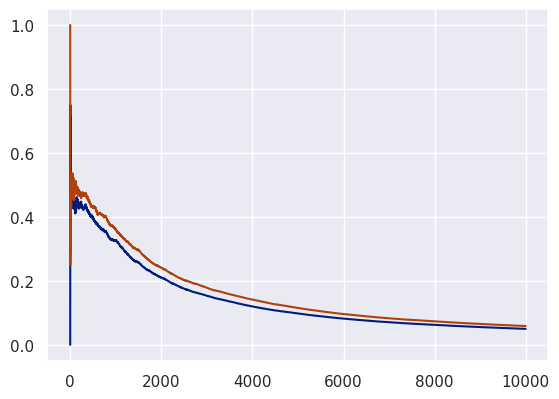

<Figure size 640x480 with 0 Axes>

In [40]:
s, l = SA(n, f, T = 10**4, radius=1, alpha=0.5)
utils.quickplot(s, l)

## d) Permutation distance metric

### Kendall Tau distance

$$ K(v, u) = |\{ (i,j):i<j, [v(i) < v(i) \land u(i) > u(j)] \lor [v(i) > v(i) \land u(i) < u(j)] \}|$$

In [8]:
def kendall(v, u):
	rv, ru = np.argsort(v), np.argsort(u)
	ones = np.ones((len(v), 1))
	V, U = ones * rv, ones * ru
	return np.logical_or(np.logical_and(V < V.T, U > U.T), np.logical_and(V > V.T, U < U.T)).sum() // 2

In [9]:
print(
	kendall( (0, 1, 2), (2, 1, 0) ),
	kendall( (1, 0, 2), (1, 2, 0) ),
	kendall( (0,), (0,) ),
)

3 1 0


### Minimal distance

In [10]:
def mindist(v, u):
	v = Permutation(v)
	u = Permutation(u)
	return v.get_positional_distance(u)

In [11]:
print(
	mindist( (0, 1, 2), (2, 1, 0) ),
	mindist( (1, 0, 2), (1, 2, 0) ),
	mindist( (0,), (0,) ),
)

4 4 0


### Plot f(p) - f(q) and kendall(p, q)

In [41]:
def SA(n, qap_objective_function, metric = None, T = 500000, radius = 1, alpha = 1.0):
	distance = []
	difference = []
	p = np.random.permutation(n)
	p_cost = qap_objective_function(p)
	costs = np.zeros(T)
	for t in range(T):
		q = random_neighbor(p, radius)
		q_cost = qap_objective_function(q)
		if(q_cost < p_cost):
			difference.append(p_cost - q_cost)
			distance.append(metric(q, p))
			p, p_cost = q, q_cost
		elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
			p, p_cost = q, q_cost
		costs[t] = p_cost
	return difference, distance

Problem size: 20
Flow matrix:
 (20, 20)
Distance matrix:
 (20, 20)


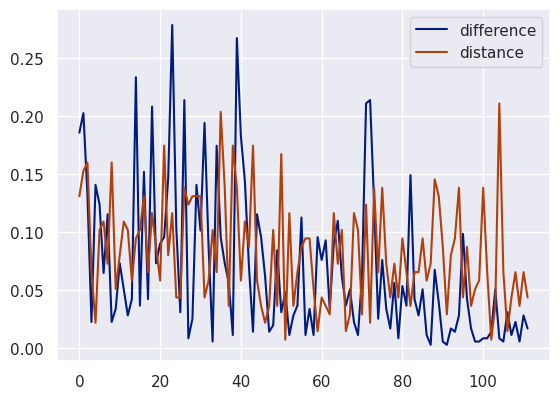

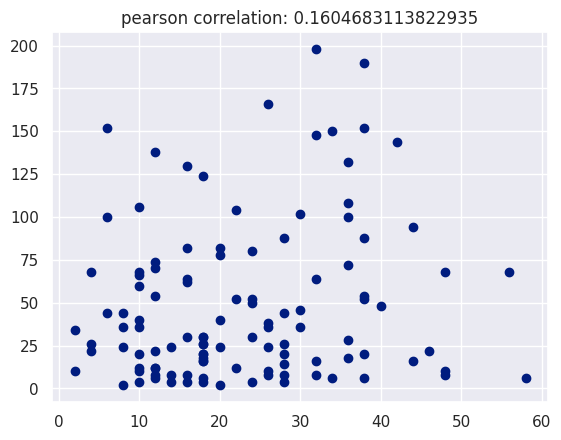

In [45]:
n, f = load_problem_instance("https://www.opt.math.tugraz.at/qaplib/data.d/nug20.dat")
diff, dist = SA(n, f, metric=kendall, T = 10**4, radius=2, alpha=1.0)

utils.quickplot(diff / np.linalg.norm(diff), dist / np.linalg.norm(dist), legend = ["difference", "distance"])
plt.title(f"pearson correlation: {scipy.stats.pearsonr(diff, dist)[0]}")
plt.scatter(dist, diff)

Problem size: 20
Flow matrix:
 (20, 20)
Distance matrix:
 (20, 20)


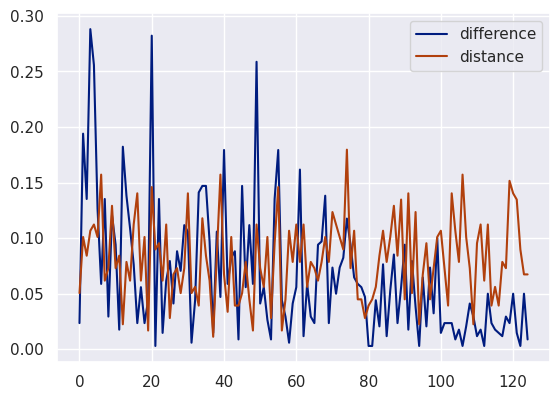

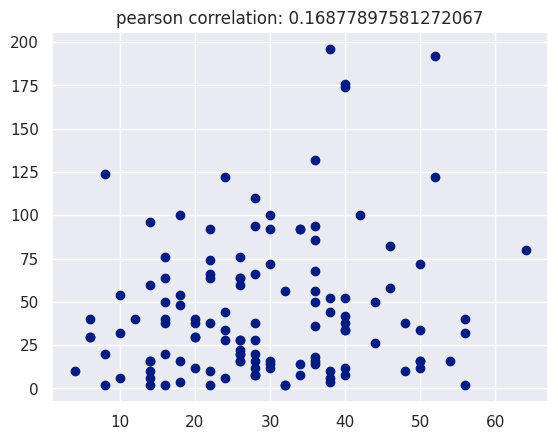

In [46]:
n, f = load_problem_instance("https://www.opt.math.tugraz.at/qaplib/data.d/nug20.dat")
diff, dist = SA(n, f, metric=mindist, T = 10**4, radius=2, alpha=1.0)

utils.quickplot(diff / np.linalg.norm(diff), dist / np.linalg.norm(dist), legend = ["difference", "distance"])
plt.title(f"pearson correlation: {scipy.stats.pearsonr(diff, dist)[0]}")
plt.scatter(dist, diff)

## e) Failure acceptance criterium

In [73]:
def generic(q_cost, p_cost, t, T, alpha):
	return np.exp(-alpha * (q_cost - p_cost) * t/T)

In [74]:
def diffexp(q_cost, p_cost, t, T, alpha):
	return np.exp(-(q_cost - p_cost)**alpha * t/T)

In [75]:
def tempexp(q_cost, p_cost, t, T, alpha):
	return np.exp(-alpha * (q_cost - p_cost)**(1 - t/T))

In [76]:
def SA(n, qap_objective_function, criterium, T = 500000, radius = 1, alpha = 1.0):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if q_cost < p_cost:
            p, p_cost = q, q_cost
        elif np.random.rand() < criterium(q_cost, p_cost, t, T, alpha):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    return p, costs

Problem size: 20
Flow matrix:
 (20, 20)
Distance matrix:
 (20, 20)
2616.0


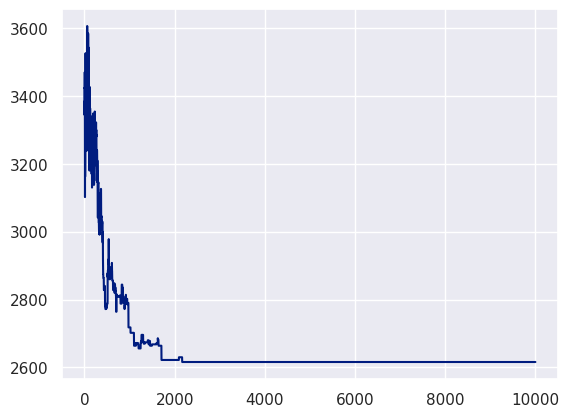

In [77]:
n, f = load_problem_instance("https://www.opt.math.tugraz.at/qaplib/data.d/nug20.dat")
p, costs = SA(n, f, generic, T=10**4)
print(min(costs))
plt.figure()
plt.plot(costs)
plt.show()

Problem size: 20
Flow matrix:
 (20, 20)
Distance matrix:
 (20, 20)
2660.0


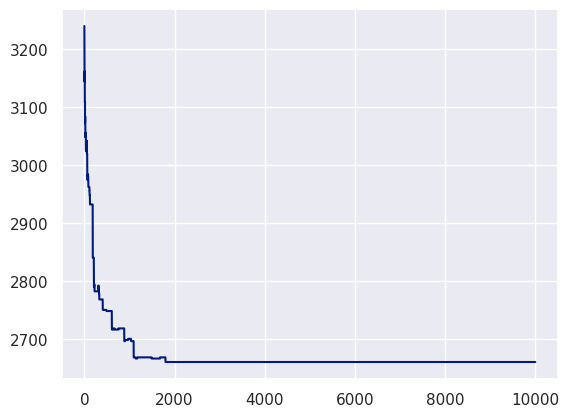

In [78]:
n, f = load_problem_instance("https://www.opt.math.tugraz.at/qaplib/data.d/nug20.dat")
p, costs = SA(n, f, diffexp, alpha=2, T=10**4)
print(min(costs))
plt.figure()
plt.plot(costs)
plt.show()

Problem size: 20
Flow matrix:
 (20, 20)
Distance matrix:
 (20, 20)
2646.0


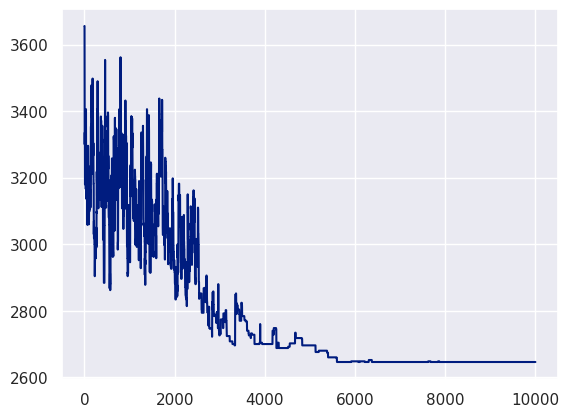

In [79]:
n, f = load_problem_instance("https://www.opt.math.tugraz.at/qaplib/data.d/nug20.dat")
p, costs = SA(n, f, tempexp, alpha=1, T=10**4)
print(min(costs))
plt.figure()
plt.plot(costs)
plt.show()